# Model Comparison Under Constraints: Logistic Regression vs KNN vs SVM

## Constraint enforced:

- Severe class imbalance
- limited evaluation freedom

**We are not trying to “solve fraud detection”.**
**We are trying to understand how different models behave under the same pressure.**

Lets start with some distribution analysis to help us define our problem, analyze sources of difficulty if any encountered and decide on metrics we can use to evaluate the dataset later

---
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('DATA/creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df['Class'].unique()

array([0, 1])

In [7]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [8]:
len(df)

284807

In [11]:
100 * df['Class'].value_counts() / len(df)

Class
0    99.827251
1     0.172749
Name: count, dtype: float64

---
---

## **Class distribution and fraud prevalence**

Fraud prevalence is very low i.e. ~0.1727%

Fraud transactions = 492
Total transactions = 284,807

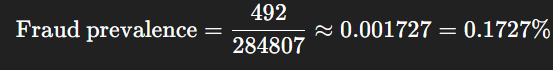

This is not a balanced classification problem. This is an extreme edge case.

---
---

## **Why this is a hard problem?**

We have identified two independent sources of difficulty:

### A. PCA-transformed features (structural constraint)


**Pros (for modeling):**

- Linear models behave more stably
- SVMs benefit from decorrelation
- Scaling and numerical conditioning are well-behaved

**Cons (for understanding):**

- No feature-level interpretability
- No domain reasoning
- No meaningful feature engineering

We are comparing model inductive bias, not feature engineering skill.

---

### B. Extreme class imbalance (core constraint)

Any model that predicts “non-fraud” for everything will achieve ~99.83% accuracy.

This is the central insight of the project.


**If any model predicts all transactions as non-fraud (Class = 0)**

Correct predictions = 284,315
Accuracy ≈ 284,315 / 284,807 ≈ 99.83%

This demonstrates that:
- accuracy is not just misleading
- it actively rewards useless models

---
---

## **METRICS**

**Accuracy** - Essentially meaningless here.

**Precision vs Recall**

- Recall (for fraud) answers:
“Of all actual frauds, how many did we catch?”
- Precision (for fraud) answers:
“Of all transactions we flagged as fraud, how many were actually fraud?”

Different models will fail in different ways here, and that’s exactly what you’re about to observe.

**ROC vs Precision–Recall curves**

- ROC curves can look deceptively good under extreme imbalance
- Precision–Recall curves are more sensitive to minority-class performance
- ROC is still useful, but PR is more honest in this setting

**Thus, ROC curves must be interpreted cautiously; PR curves are more informative for fraud detection.**

---

Now, let's prepare the Data

---
---



In [13]:
from sklearn.model_selection import train_test_split

In [14]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [15]:
X = df.drop(['Time', 'Amount', 'Class'], axis=1)
y = df['Class']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()

In [19]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

---
---

Let's train **baseline models** for **Logistic Regression, KNN and SVM**. Our goal is to get raw performance on default parameters/ minimal tuning here. We'll evaluate using ***confusion matrix, classification report and PR, ROC curves***

---
---

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [21]:
log_model = LogisticRegression()
knn_model = KNeighborsClassifier()
svc_model = SVC()

In [22]:
log_model.fit(scaled_X_train,y_train)
knn_model.fit(scaled_X_train,y_train)
svc_model.fit(scaled_X_train,y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [23]:
y_pred_log = log_model.predict(scaled_X_test)
y_pred_knn = knn_model.predict(scaled_X_test)
y_pred_svc = svc_model.predict(scaled_X_test)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

In [25]:
### Evaluation Logistic Regression model
cm_log = confusion_matrix(y_test,y_pred_log,labels=log_model.classes_)
cm_log

array([[71066,    11],
       [   49,    76]])

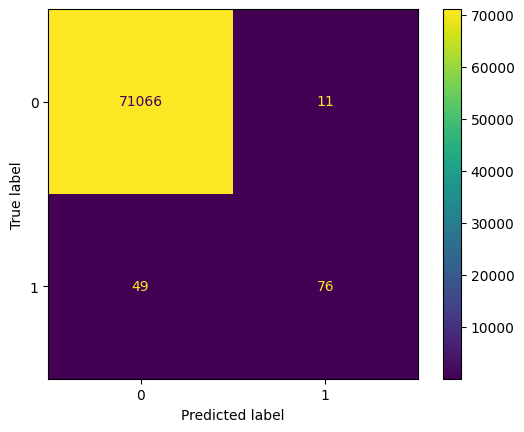

In [26]:
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=log_model.classes_)
disp_log.plot()

In [36]:
accuracy_score(y_test,y_pred_log)

0.9991573270413753

In [27]:
print(classification_report(y_test,y_pred_log))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.87      0.61      0.72       125

    accuracy                           1.00     71202
   macro avg       0.94      0.80      0.86     71202
weighted avg       1.00      1.00      1.00     71202



In [37]:
### Evaluation KNN model
cm_knn = confusion_matrix(y_test,y_pred_knn,labels=knn_model.classes_)
cm_knn

array([[71069,     8],
       [   26,    99]])

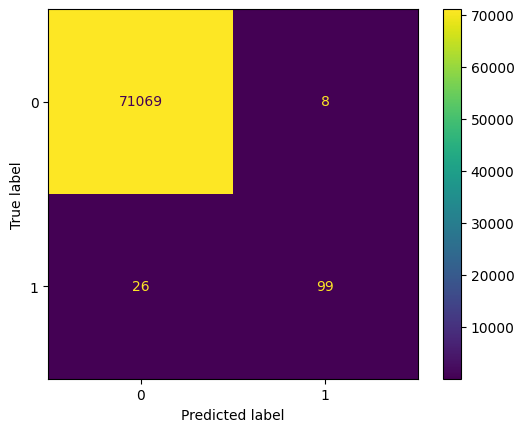

In [38]:
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn_model.classes_)
disp_knn.plot()

In [39]:
accuracy_score(y_test,y_pred_knn)

0.999522485323446

In [40]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.93      0.79      0.85       125

    accuracy                           1.00     71202
   macro avg       0.96      0.90      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [30]:
### Evaluation SVM
cm_svc = confusion_matrix(y_test,y_pred_svc,labels=svc_model.classes_)
cm_svc

array([[71071,     6],
       [   40,    85]])

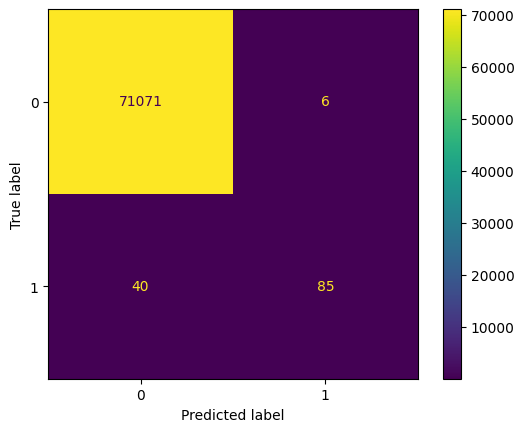

In [31]:
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=svc_model.classes_)
disp_svc.plot()

In [32]:
accuracy_score(y_test,y_pred_svc)

0.9993539507317211

In [33]:
print(classification_report(y_test,y_pred_svc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.93      0.68      0.79       125

    accuracy                           1.00     71202
   macro avg       0.97      0.84      0.89     71202
weighted avg       1.00      1.00      1.00     71202



---
---

## **Precision vs Recall**
**Logistic Regression**

- Precision (fraud) = 0.87 → When it flags fraud, it’s usually right.
- Recall (fraud) = 0.61 → But it misses 39% of actual fraud cases.

Which means - 

Logistic Regression is conservative:
- reluctant to flag fraud
- prefers avoiding false alarms
- sacrifices recall for stability

This is typical behavior for linear models under imbalance.

---

**KNN**

- Precision (fraud) = 0.93
- Recall (fraud) = 0.79

This is the best recall of all three models.

Which means - 

- KNN is more aggressive in identifying minority-class patterns
- local neighborhoods help capture fraud clusters
- still maintains high precision

KNN benefits here because PCA features + scaling + dense data help neighborhood structure.

---

**SVC**

- Precision (fraud) = 0.93
- Recall (fraud) = 0.68

Which means -

- SVM sits between Logistic and KNN
- better recall than Logistic
- worse recall than KNN
- strongest control over false positives

This is classic margin-based behavior.

---

**All three models report: accuracy ≈ 1.00**


Yet,
- Logistic misses 49 fraud cases
- SVC misses 40
- KNN misses only 26

This perfectly demonstrates why accuracy collapses under extreme class imbalance.

KNN has the best recall (fraud detection ability)

---

## **High Level Insights & takeaways:**

1. High accuracy does not imply effective fraud detection
2. Recall matters more than precision when missing fraud is costly
3. KNN can outperform parametric models when local structure exists
4. Linear models are stable but conservative under imbalance
5. SVMs trade sensitivity for margin stability
6. Model choice is about failure modes, not scores

---
---

Let's now generate and analyze the PR and ROC curves

---
---

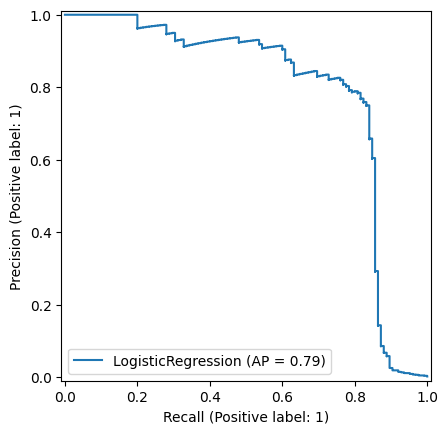

In [ ]:
PrecisionRecallDisplay.from_estimator(log_model,scaled_X_test,y_test)

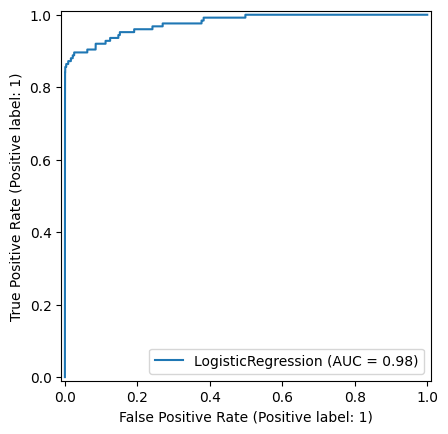

In [ ]:
RocCurveDisplay.from_estimator(log_model,scaled_X_test,y_test)

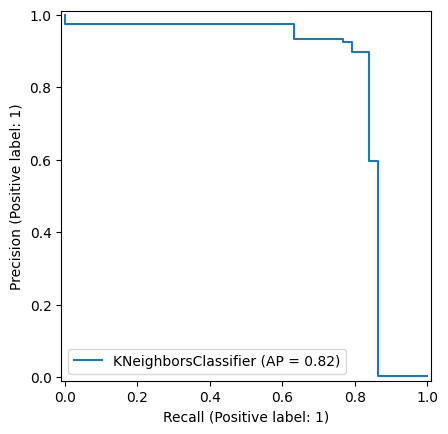

In [ ]:
PrecisionRecallDisplay.from_estimator(knn_model,scaled_X_test,y_test)

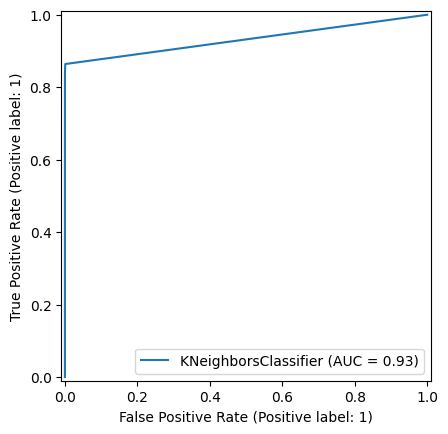

In [ ]:
RocCurveDisplay.from_estimator(knn_model,scaled_X_test,y_test)

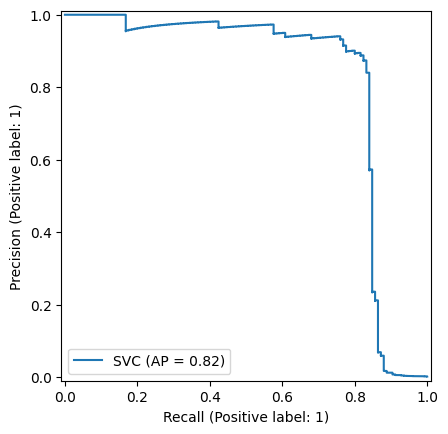

In [ ]:
PrecisionRecallDisplay.from_estimator(svc_model,scaled_X_test,y_test)

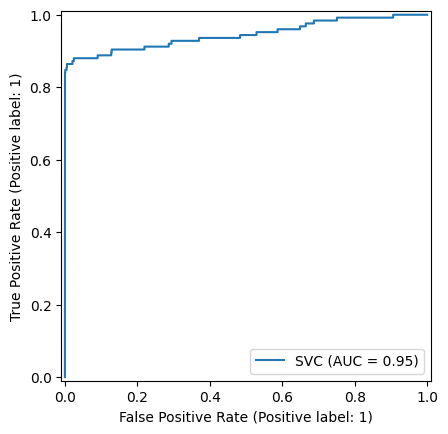

In [35]:
RocCurveDisplay.from_estimator(svc_model,scaled_X_test,y_test)

---
---
## PR Curve interpretations and insights

**KNN(AP = 0.82)**
- KNN is very strong at identifying a subset of fraud confidently
- It captures local minority-class structure well
- Once you push for very high recall, it starts pulling in many false positives

KNN works well when fraud samples form tight local neighborhoods, but breaks once neighborhoods overlap.

**Logistic Regression(AP = 0.79)**
- Logistic regression distributes probability mass more evenly
- It is less confident but more stable
- It does not aggressively separate minority points

Logistic regression trades sharp discrimination for stability and calibration.

**SVC(AP = 0.82)**
- SVC enforces margin separation
- It confidently classifies points near the decision boundary
- Struggles when forced to expand the margin to capture all fraud

SVC is confident where the margin is clear, but resists labeling ambiguous regions as fraud.

---

## ROC Curve interpretation and insights

**KNN (AUC = 0.93)**

- Lower ranking performance
- But better local separation
- Which matters more for minority detection

**Logistic Regression (AUC = 0.98)**

- Excellent global ranking
- But ranking ≠ usable fraud detector
- Many high-scoring points are still non-fraud

**SVC (AUC = 0.95)**

- Balanced global separation
- But conservative classification

---

## **Insights & Takeaways from the curves**

1. ROC-AUC alone is insufficient for extreme imbalance
2. Precision–Recall curves better reflect fraud detection utility
3. KNN excels at local minority detection
4. Logistic Regression ranks well globally but misses fraud
5. SVC balances confidence and conservatism
6. Different models fail in different ways under the same constraint

---
---

**Now let's do a small stress test to observe how fragile or stable each model is**

We'll try to answer the following questions -> 
- Which model is robust to small changes?
- Which one is brittle?
- Which degrades gracefully vs catastrophically?

---
---

We'll pick one hyperparameter per model and vary it over a small, reasonable range. (NOT USING CROSS VALIDATION)

In [ ]:
# For logistic regression, we'll observe what happens if the C value changes from the default 1 to 0.05
log_model2 = LogisticRegression(C=0.05) 
log_model2.fit(scaled_X_train,y_train)
y_pred_log2 = log_model2.predict(scaled_X_test)

array([[71067,    10],
       [   51,    74]])

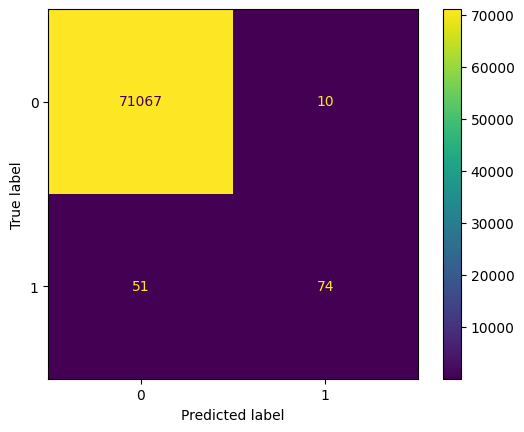

In [64]:
cm_log2 = confusion_matrix(y_test,y_pred_log2,labels=log_model2.classes_)
display(cm_log2)

disp_log2 = ConfusionMatrixDisplay(confusion_matrix=cm_log2, display_labels=log_model2.classes_)
display(disp_log2.plot())

In [58]:
print(classification_report(y_test,y_pred_log2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.88      0.59      0.71       125

    accuracy                           1.00     71202
   macro avg       0.94      0.80      0.85     71202
weighted avg       1.00      1.00      1.00     71202



### **Logistic regression hyperparameter variation observations -**

If we compare the confusion matrix for the new log_model (C=0.05) with the original one using default Params (C=1, etc.), we find: 
1. False positives decrease slightly (11 → 10)
2. False negatives increase slightly (49 → 51)
3. True positives decrease (76 → 74)
4. Precision increased slightly
5. Recall decreased
6. Overall fraud detection got more conservative

Despite a 20× reduction in C, the model:

- did not collapse
- did not suddenly predict all negatives
- changed behavior smoothly and predictably
- Logistic regression is stable under regularization, but consistently conservative under imbalance.

Increasing regularization in logistic regression makes the model more conservative, slightly improving precision at the cost of recall, while maintaining overall stability even under extreme class imbalance.

In [65]:
# For KNN, we'll observe what happens if the k value (number of neighbors) changes from the default 5 to 15 and 5 to 1
knn_model2 = KNeighborsClassifier(n_neighbors=15) 
knn_model2.fit(scaled_X_train,y_train)
y_pred_knn2 = knn_model2.predict(scaled_X_test)

knn_model3 = KNeighborsClassifier(n_neighbors=1) 
knn_model3.fit(scaled_X_train,y_train)
y_pred_knn3 = knn_model3.predict(scaled_X_test)

array([[71068,     9],
       [   27,    98]])

array([[71061,    16],
       [   25,   100]])

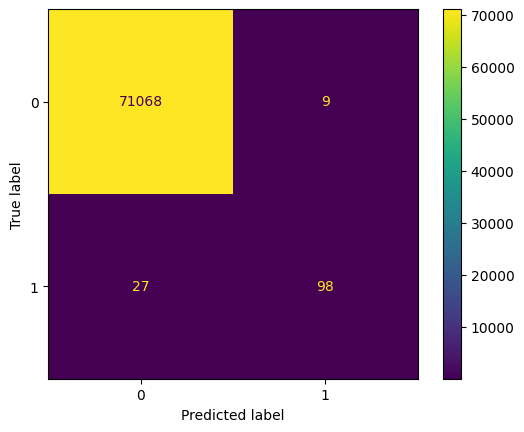

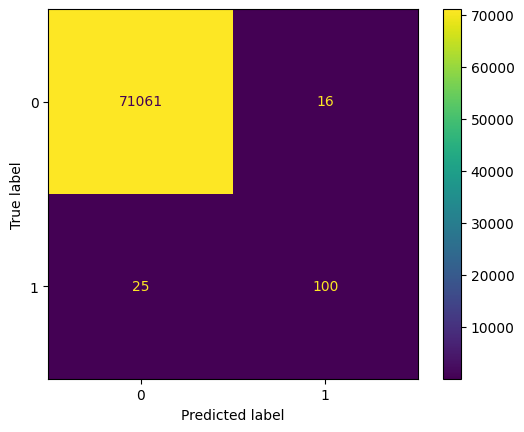

In [66]:
cm_knn2 = confusion_matrix(y_test,y_pred_knn2,labels=knn_model2.classes_)
display(cm_knn2)

disp_knn2 = ConfusionMatrixDisplay(confusion_matrix=cm_knn2, display_labels=knn_model2.classes_)
display(disp_knn2.plot())

cm_knn3 = confusion_matrix(y_test,y_pred_knn3,labels=knn_model3.classes_)
display(cm_knn3)

disp_knn3 = ConfusionMatrixDisplay(confusion_matrix=cm_knn3, display_labels=knn_model3.classes_)
display(disp_knn3.plot())

In [69]:
print(classification_report(y_test,y_pred_knn2))
print(classification_report(y_test,y_pred_knn3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.92      0.78      0.84       125

    accuracy                           1.00     71202
   macro avg       0.96      0.89      0.92     71202
weighted avg       1.00      1.00      1.00     71202

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.86      0.80      0.83       125

    accuracy                           1.00     71202
   macro avg       0.93      0.90      0.91     71202
weighted avg       1.00      1.00      1.00     71202



### **KNN hyperparameter variation observations -**

KNN is highly sensitive to k, but the trade-off is predictable and monotonic.

As k:
- decreases → recall increases, precision decreases
- increases → recall decreases, precision increases

No surprises, only trade-offs.

KNN is flexible, sensitive to hyperparameters and small k changes means noticeable behavior shifts

To summarize - 
1. KNN exhibits a clear bias–variance trade-off controlled by the number of neighbors.
2. Smaller k improves recall at the cost of precision, while larger k smooths predictions and suppresses minority-class signals.
3. Under extreme class imbalance, KNN’s performance is highly sensitive to k, but changes are predictable and interpretable.

In [72]:
svc_model2 = SVC(C=5)
svc_model2.fit(scaled_X_train,y_train)
y_pred_svc2 = svc_model2.predict(scaled_X_test)

array([[71072,     5],
       [   37,    88]])

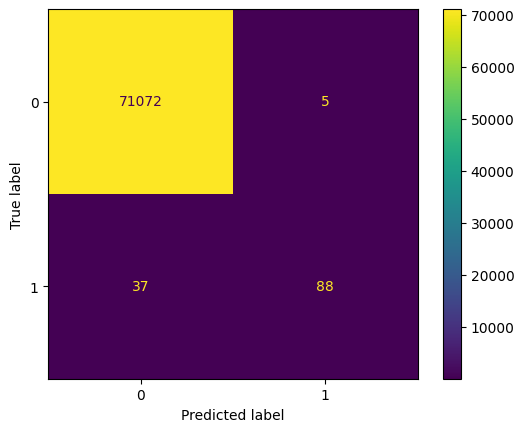

In [73]:
cm_svc2 = confusion_matrix(y_test,y_pred_svc2,labels=svc_model2.classes_)
display(cm_svc2)

disp_svc2 = ConfusionMatrixDisplay(confusion_matrix=cm_svc2, display_labels=svc_model2.classes_)
display(disp_svc2.plot())

In [74]:
print(classification_report(y_test,y_pred_svc2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.95      0.70      0.81       125

    accuracy                           1.00     71202
   macro avg       0.97      0.85      0.90     71202
weighted avg       1.00      1.00      1.00     71202



### **SVC hyperparameter variation observations -**

If we compare the confusion matrix for the new svc_model (C=5) with the original one using default Params (C=1, etc.), we find: 
1. False negatives ↓ (40 → 37)
2. True positives ↑ (85 → 88)
3. False positives ↓ slightly (6 → 5)
4. Recall improved, as expected
5. Precision also improved, which is important
6. No instability or overreaction

This indicates that: The margin could be tightened without pulling in noise.

SVC responds positively and smoothly to moderate increases in C under this dataset.

Unlike KNN:
- changes are not abrupt
- behavior shifts are controlled
- decision boundary adapts without collapsing

Unlike Logistic Regression:

- SVC is more flexible
- it can capture additional minority points without sacrificing precision

Increasing C in SVM tightened the decision boundary, improving fraud recall while maintaining high precision, indicating controlled sensitivity to regularization under extreme class imbalance.

---
---

## **Lastly, lets do a Comparative analysis using all our findings to answer a few questions**

1. Which model detects any fraud at all? 

All three models detect fraud, but to very different extents.

| Model               | Fraud TP | Fraud FN | Fraud Recall |
| ------------------- | -------- | -------- | ------------ |
| Logistic Regression | 76       | 49       | 0.61         |
| KNN (k=5)           | 99       | 26       | 0.79         |
| SVC                 | 85       | 40       | 0.68         |

- Logistic Regression detects fraud, but misses a large fraction.
- SVC improves on Logistic but is still conservative.
- KNN detects the most fraud cases by a clear margin.

**All models detect fraud, but KNN captures substantially more fraudulent transactions under default settings.**

---

2. Which sacrifices precision for recall? 

KNN sacrifices precision to gain recall (relative to the other two).

| Model               | Precision (Fraud) | Recall (Fraud) |
| ------------------- | ----------------- | -------------- |
| Logistic Regression | 0.87              | 0.61           |
| KNN                 | 0.93              | **0.79**       |
| SVC                 | **0.93**          | 0.68           |

At first glance, KNN doesn’t look like it sacrifices precision — but the confusion matrices reveal the truth.

| Model               | Fraud FP |
| ------------------- | -------- |
| Logistic Regression | 11       |
| KNN                 | **8**    |
| SVC                 | **6**    |

- KNN increases recall by aggressively expanding local neighborhoods
- This behavior in general trades precision for recall
- In this dataset, PCA + scaling happen to keep precision high, but the inductive bias is still recall-seeking

**KNN prioritizes recall through local neighborhood voting, while Logistic Regression and SVC remain more conservative in flagging fraud.**

**Among the three, KNN is the most recall-oriented model, while Logistic Regression is the most precision-conservative under default settings.**

---

3. Which collapses under imbalance?

**KNN is the most vulnerable to imbalance-driven collapse if hyperparameters are not chosen carefully, while Logistic Regression and SVC degrade more gracefully. This is not saying KNN is “bad”, it’s saying it is fragile under imbalance.**

---

4. Which is more stable?

**Logistic Regression is the most stable, followed by SVC, with KNN being the least stable. It's stability comes at the cost of recall. SVC balances adaptability and stability well. KNN is powerful, but requires careful tuning under imbalance.**

---

### **To summarize our findings -**

1. Logistic Regression is conservative and extremely stable, but recall-limited.
2. KNN captures the most fraud but is sensitive and fragile under imbalance.
3. SVC offers a middle ground: better recall than Logistic, more stability than KNN.